# Wine Dataset

In [96]:
# Importing dependencies

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

## Loading Wine Dataset

In [98]:
wine_data = pd.read_csv('winequalityN.csv')

### Understanding the Dataset

In [100]:
# Checking the first 5 rows of dataset
print(wine_data.head())

# Checking the column names
print(wine_data.columns)

    type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white            7.0              0.27         0.36            20.7   
1  white            6.3              0.30         0.34             1.6   
2  white            8.1              0.28         0.40             6.9   
3  white            7.2              0.23         0.32             8.5   
4  white            7.2              0.23         0.32             8.5   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.045                 45.0                 170.0   1.0010  3.00   
1      0.049                 14.0                 132.0   0.9940  3.30   
2      0.050                 30.0                  97.0   0.9951  3.26   
3      0.058                 47.0                 186.0   0.9956  3.19   
4      0.058                 47.0                 186.0   0.9956  3.19   

   sulphates  alcohol  quality  
0       0.45      8.8        6  
1       0.49      9.5        6  
2       0.4

### Predicting Wine Quality, based on wine features

Epoch 1/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.2202 - loss: 2.2846 - val_accuracy: 0.4919 - val_loss: 1.3752 - learning_rate: 0.0010
Epoch 2/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4549 - loss: 1.5137 - val_accuracy: 0.5104 - val_loss: 1.1904 - learning_rate: 0.0010
Epoch 3/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5015 - loss: 1.3079 - val_accuracy: 0.5329 - val_loss: 1.1095 - learning_rate: 0.0010
Epoch 4/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5116 - loss: 1.2087 - val_accuracy: 0.5352 - val_loss: 1.0782 - learning_rate: 0.0010
Epoch 5/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5158 - loss: 1.1549 - val_accuracy: 0.5367 - val_loss: 1.0657 - learning_rate: 0.0010
Epoch 6/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5177 - loss: 1.1157 - val_accuracy: 0.5491 - val_loss: 1.0528 - learning_rate: 0.0010
Epoch 7/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5369 - loss: 

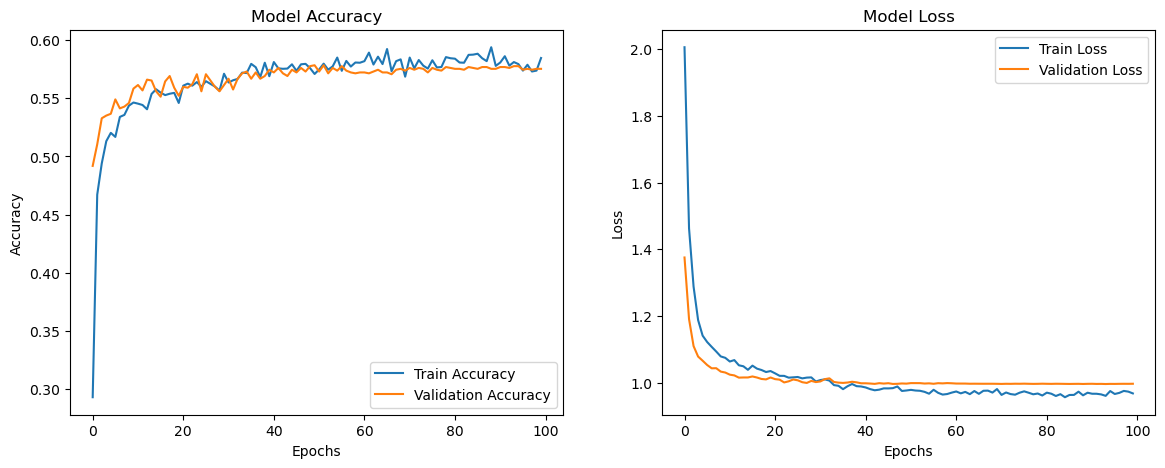

In [92]:
# Processing the dataset for the model

# One-hot encode 'type' column, to convert type = white as 1 and type = red as 0 
wine_data = pd.get_dummies(wine_data, columns=['type'], drop_first=True)

# Handling the missing values, dropping rows from dataset that contain missing value
wine_data = wine_data.dropna()

# Separating features and target
X = wine_data.drop('quality', axis=1)
y = wine_data['quality']

# Normalizing the features to have mean of 0 and standard deviation of 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert target to zero-based categorical, here we made sure that the quality ratings starts from 0 and then catogarized it
y_zero_based = y - y.min()
y_categorical = to_categorical(y_zero_based, num_classes=len(y.unique()))

# Spliting wine dataset into training and testing sets, 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_categorical, test_size=0.2, random_state=42)

# Building the neural network model

# Initializing the neural network model using Keras's Sequential() model
model = Sequential()

# Input layer, same shape that of our features
model.add(Input(shape=(X_train.shape[1],)))  

# 3 Hidden Layers
# Here we are choosing 3 layers so than model can also learn non-linear patterns, and 
# We are decreasing 30% of neurons in very layer just to reduce overfitting
# BatchNormalization to normalize the output of one layer

model.add(Dense(128, activation='relu'))   # Hidden layer 1
model.add(BatchNormalization())
model.add(Dropout(0.3))


model.add(Dense(64, activation='relu'))   # Hidden layer 2
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))   # Hidden layer 3
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Output layer with neurons equal to the number of unique classes in the target variable
model.add(Dense(y_train.shape[1], activation='softmax'))   # Softmax Activation used for multi-class classification


# Compiling the neural network model
# Adam optimizer used to controls how the neural network adjusts its weights in response to errors during training.
# Adam optimizer has learning rate of "0.001", this tells the optimizer how big or small each adjustment should be
optimizer = Adam(learning_rate=0.001)   
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])  # The loss function is categorical_crossentropy because of multi-class classification 

# Learning rate reduction callback
# Reduce Learning Rate on Plateau of validation loss
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

# Training the model and storing the history of the training process of the model.
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[reduce_lr])

# Evaluating our model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

# Ploting training and validation accuracy/loss
def plot_learning_curves(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Ploting the learning curves
plot_learning_curves(history)

### Predicting Wine Type, based on wine features

### If you get error in running the cell below, please run top 3 code cells again, and dont run the code cell above with wine prediction model. 

Epoch 1/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7848 - loss: 0.4725 - val_accuracy: 0.9923 - val_loss: 0.0888 - learning_rate: 0.0010
Epoch 2/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9863 - loss: 0.0758 - val_accuracy: 0.9954 - val_loss: 0.0290 - learning_rate: 0.0010
Epoch 3/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9869 - loss: 0.0525 - val_accuracy: 0.9961 - val_loss: 0.0184 - learning_rate: 0.0010
Epoch 4/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9882 - loss: 0.0466 - val_accuracy: 0.9969 - val_loss: 0.0152 - learning_rate: 0.0010
Epoch 5/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9892 - loss: 0.0407 - val_accuracy: 0.9969 - val_loss: 0.0167 - learning_rate: 0.0010
Epoch 6/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9907 - loss: 0.0436 - val_accuracy: 0.9961 - val_loss: 0.0139 - learning_rate: 0.0010
Epoch 7/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9913 - loss: 0

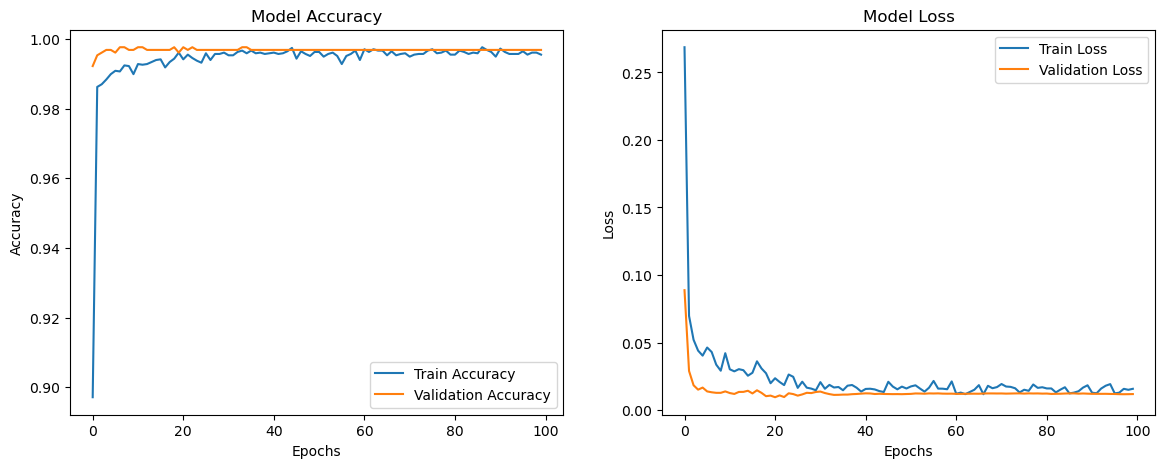

In [102]:
# Convert 'type' column to binary labels (0 for white, 1 for red)
wine_data['type'] = wine_data['type'].apply(lambda x: 1 if x == 'red' else 0)

# Handle missing values 
wine_data = wine_data.dropna()

# Separating features and target
X = wine_data.drop('type', axis=1)
y = wine_data['type']

# Normalizeing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Spliting dataset into training set and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Building the neural network model
model = Sequential()

# Input layer
model.add(Input(shape=(X_train.shape[1],)))

# Hidden Layers
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))


model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))


model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compiling the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

# Train the model, storing history
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[reduce_lr])

# Model evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

# Ploting training and validation accuracy/loss
def plot_learning_curves(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Ploting the learning curves
plot_learning_curves(history)